
# FASTSim Demonstration

<img src="icon_fastsim.jpg" | width=300> 

Developed by NREL, the Future Automotive Systems Technology Simulator (FASTSim) evaluates the impact of technology improvements on efficiency, performance, cost, and battery life in conventional vehicles, hybrid electric vehicles (HEVs), plug-in hybrid electric vehicles (PHEVs), and all-electric vehicles (EVs).

FASTSim answers questions like:
- Which battery sizes are most cost effective for a PHEV or EV?
- At what battery prices do PHEVs and EVs become cost effective?
- On average, how much fuel does a PHEV with a 30-mile electric range save?
- How much fuel savings does an HEV provide for a given drive cycle?
- How do lifetime costs and petroleum use compare for conventional vehicles, HEVs, PHEVs, and EVs?

FASTSim was originally implemented in Microsoft Excel. The pythonic implementation of FASTSim, demonstrated here, is the drive cycle energy consumption simulation component of the software. With python, it is able to run more quickly and more easily be applied to a large set of drive cycles.

In [1]:
import sys
sys.path.append('../src')
import os
import numpy as np
import sqlite3
import time
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')

%matplotlib notebook

import FASTSim

## Individual Drive Cycle
### Load Drive Cycle

Default (UDDS, US06, HWFET) cycles can be loaded from the ```../cycles``` directory, or custom cycles can be specified in the same format. The expected format is a dictionary with the following keys: 

```['cycGrade', 'cycMps', 'cycSecs', 'cycRoadType']```
- cycGrade = Road grade [%/100]
- cycMps = Vehicle speed [meters per second]
- cycSecs = Relative time in the cycles [seconds]
- cycRoadType = Indicator as to whether or not there is a wireless charging capability from the road to vehicle

There is no limit to the length of a drive cycle that can be provided as an input to FASTSim.

In [2]:
cyc = FASTSim.get_standard_cycle("UDDS")

### Load Powertrain Model

A vehicle database in CSV format is required to be in the working directory where FASTSim is running (i.e. the same directory as this notebook). The "get_veh" function selects the appropriate vehicle attributes from the database and contructs the powertrain model (engine efficiency map, etc.). An integer values corresponds to each vehicle in the database.

In [3]:
veh = FASTSim.get_veh(10)

### Run FASTSim

The "sim_drive" function takes the drive cycle and vehicle models defined above as inputs. The output is a dictionary of time series and scalar values described the simulation results. Typically of interest is the "gge" key, which is an array of time series energy consumption data at each time step in the drive cycle. 

If running FASTSim in batch over many drive cycles, output from "sim_drive" can be written to files or database for batch post-processing. 

In [4]:
output = FASTSim.sim_drive(cyc, veh)

### Results

In [5]:
df = pd.DataFrame.from_dict(output)[['soc', 'kwh']]
df['speed'] = cyc['cycMps'] * 2.23694  # Convert mps to mph

<IPython.core.display.Javascript object>


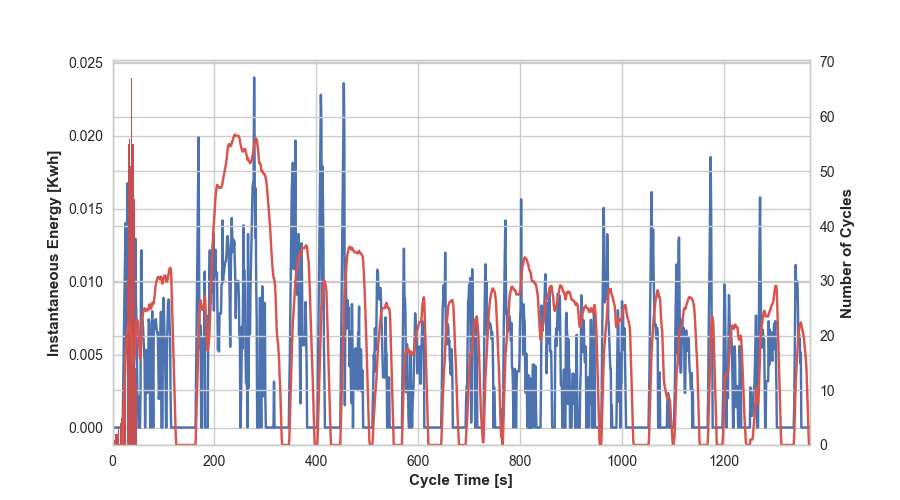

In [11]:
fig, ax = plt.subplots(figsize=(9, 5))
kwh_line = df.kwh.plot(ax=ax, label='Kwh')

ax2 = ax.twinx()
speed_line = df.speed.plot(color='xkcd:pale red', ax=ax2, label='Speed')

ax2.grid(False)
ax.set_xlabel('Cycle Time [s]', weight='bold')
ax.set_ylabel('Instantaneous Energy [Kwh]', weight='bold')
ax2.set_ylabel('Speed [MPH]', weight='bold')

## Batch Drive Cycles

FASTSim's most significant advantage over other powertrain simulation tools comes from the ability to simulate many drive cycles quickly. The same three steps described about (load cycle, load model, run FASTSim) will be used here, however, the demonstration highlights how quickly FASTSim runs over __16,694 miles of driving__ data for 25 vehicles. The drive cycles are from the Chicago area and are stored in a SQLite database. Running on a single core, the 494 drive cycles take on the order of minute to run, averaging a fraction of a second per drive cycle.

### Load Model, Load Cycles, Run FASTSim

In [12]:
data_path = '../cycles/cmap_subset/'  # path to sqlite db
veh = FASTSim.get_veh(1)  # load vehicle model
output_dict = {}

conn = sqlite3.connect(data_path + 'cmap_25_vehs_494trips.db')
pnts_df = pd.read_sql_query(
    'SELECT * FROM gps_points', conn, index_col='index')  # load drive cycles
conn.close()

In [13]:
missed_cycs = 0
results_df = pd.DataFrame()
t_start = time.time()
for trp in list(pnts_df.nrel_trip_id.unique()):
    if trp == -1: continue

    pnts = pnts_df[pnts_df['nrel_trip_id'] == trp]
    pnts['time_local'] = pd.to_datetime(pnts['time_local'])

    cyc = {}
    cyc['cycGrade'] = np.zeros(len(pnts))
    cyc['cycMps'] = np.array(
        pnts['gpsspeed'] * 0.44704)  # MPH to MPS conversion
    cyc['cycSecs'] = np.array(
        np.cumsum(
            (pnts['time_local'] -
             pnts['time_local'].shift()).fillna(0).astype('timedelta64[s]')))
    cyc['cycRoadType'] = np.zeros(len(pnts))

    output = FASTSim.sim_drive(cyc, veh)
    del output['soc'], output['kwh']
    output['nrel_trip_id'] = trp
    results_df = results_df.append(output, ignore_index=True)
t_end = time.time()

results_df = results_df.astype(float)

print 'Run Complete. Total runtime = %1.2fs' % (t_end - t_start)
print '     Average time per cycle = %1.2fs' % ((
    t_end - t_start) / len(pnts_df.nrel_trip_id.unique()))

Run Complete. Total runtime = 54.62s
     Average time per cycle = 0.11s


### Results

In this demo, the batch results from all 494 drive cycles were output to a Pandas Dataframe to simplify post-processing. Any python data structure or output file format can be used to save batch results. For simplicity, time series data was not stored, but it could certainly be included in batch processing.

In order to plot the data, a handful of results are filtered out either because they are much longer than we are interested in, or there was some GPS issue in data acquisition that led to an unrealistically high cycle average speed.

In [21]:
df_fltr = results_df[(results_df['distance_mi'] < 1000)
                     & (results_df['distance_mi'] > 0) &
                     (results_df['avg_speed_mph'] < 100)]

<IPython.core.display.Javascript object>


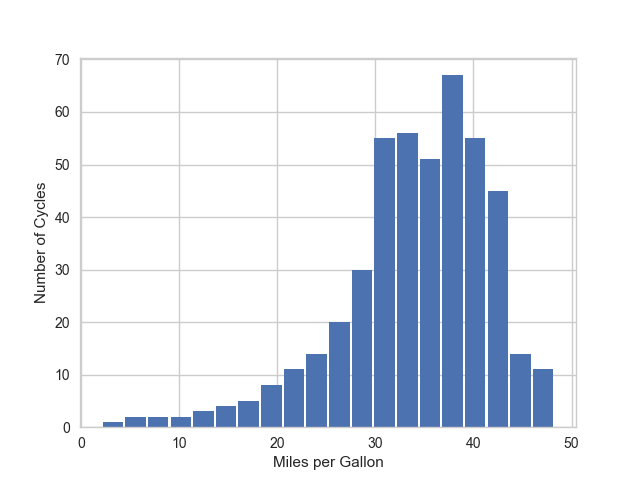

In [22]:
plt.figure()
df_fltr.mpgge.hist(bins=20, rwidth=.9)
plt.xlabel('Miles per Gallon')
plt.ylabel('Number of Cycles')

<IPython.core.display.Javascript object>


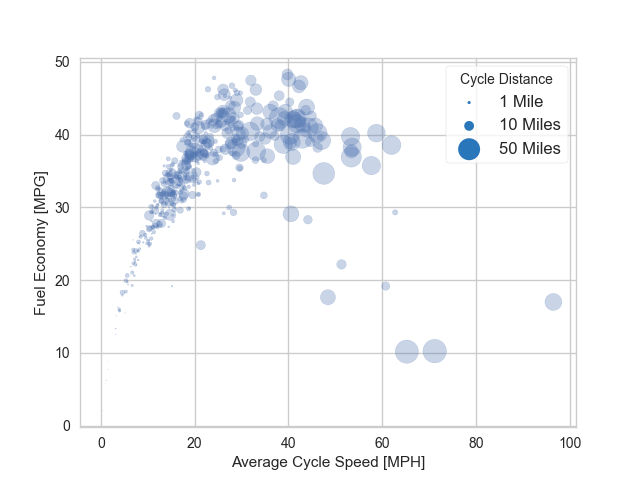

In [23]:
df_fltr.plot(
    x='avg_speed_mph',
    y='mpgge',
    kind='scatter',
    s=df_fltr['distance_mi'] * 5,
    alpha=0.3)

# Configure legend and axes
l1 = plt.scatter([], [], s=5, edgecolors='none', c='xkcd:bluish')
l2 = plt.scatter([], [], s=50, edgecolors='none', c='xkcd:bluish')
l3 = plt.scatter([], [], s=250, edgecolors='none', c='xkcd:bluish')

labels = ["1 Mile", "10 Miles", "50 Miles"]

leg = plt.legend(
    [l1, l2, l3],
    labels,
    title='Cycle Distance',
    frameon=True,
    fontsize=12,
    scatterpoints=1)
plt.xlabel('Average Cycle Speed [MPH]')
plt.ylabel('Fuel Economy [MPG]')